In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


##### Shape of Dataset
* No of datapoints - 1030
* No of features - 9

In [3]:
df.shape

(1030, 9)

* All the independent features are numeric datatype
* Also there is no direct null values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


* From this 5 point summary, we can see all the featurea have different range of values.
* So we have to scale it to make sure that our model gives equal importance to all the features.

In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


##### Univariate Anaylsis
* From this analysis we can see that each independent features have around three gaussians
* Even though the strength is fairly normally distributed, due to this multiple gaussians in the independent features there is  small nodes in the target distribution

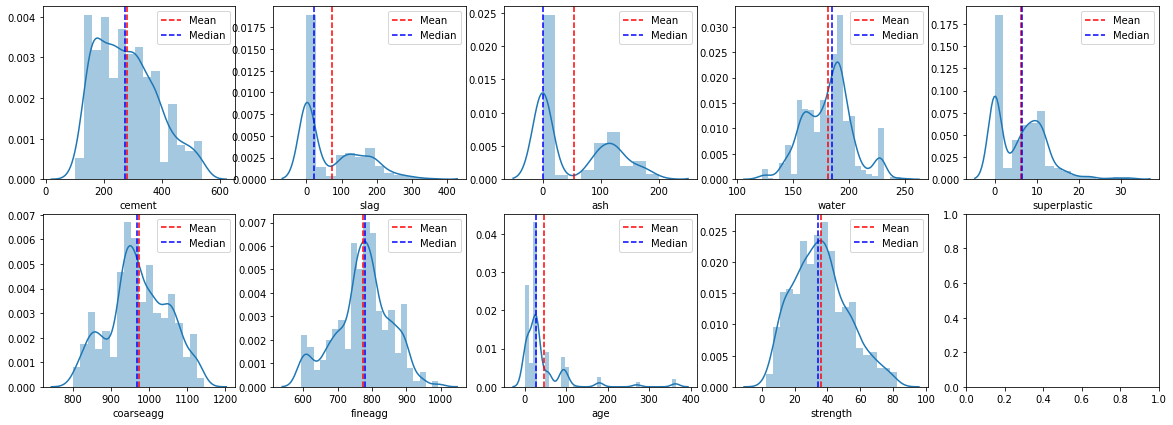

In [6]:
fig, axes = plt.subplots(nrows=2, ncols =5, figsize=[20,7])
columns = df.columns
for col, ax in zip(columns, axes.flatten()):
  sns.distplot(df[col], ax=ax)
  mean = df[col].mean()
  median = df[col].median()
  ax.axvline(mean, color = 'r', linestyle='--')
  ax.axvline(median, color = 'b', linestyle='--')
  ax.legend({'Mean': mean, 'Median': median})

##### Box plot to check the outliers
* There are few outliers in slag, Ash, Superplastic, fineagg, age.
* Here as per the problem statement these are ingredients of the concrete.
* The ingredients can take any values and it may be an outlier in the distribution but it is valid value.
* We should be able to predict the output even in such conditions.
* Replacing the values of slag, ash, superplastic, fineagg and age may greatly change the strength of concrete.
* We are not treating the outliers in this problem statement but trying to build a model which can handle this. 

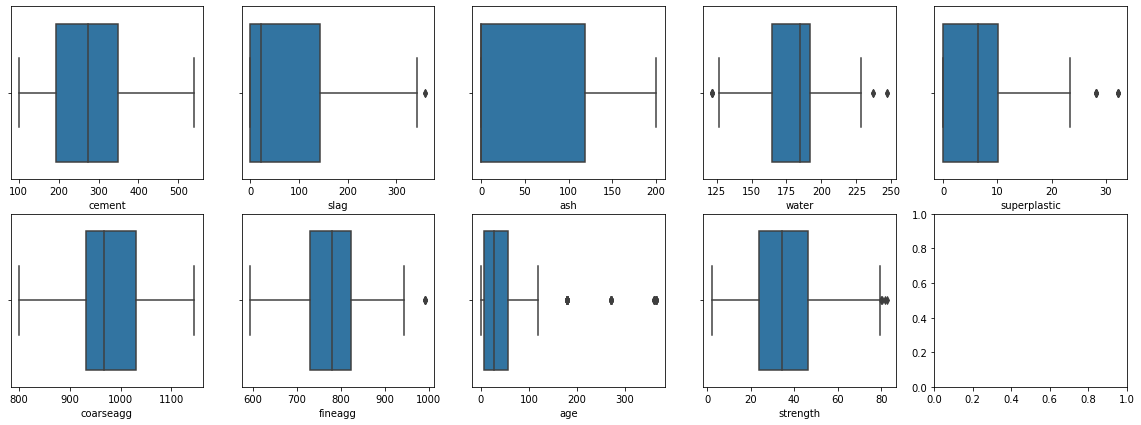

In [7]:
fig, axes = plt.subplots(nrows=2, ncols =5, figsize=[20,7])
columns = df.columns
for col, ax in zip(columns, axes.flatten()):
  sns.boxplot(df[col], ax=ax)

* From this plot we can see that there is no high correlation between features.
* Also cement, superplastic and age have some postive correlation with the strength of the concrete.So increasing the cement, superplastic and also on getting older the strength of the concrete increases to some extend.

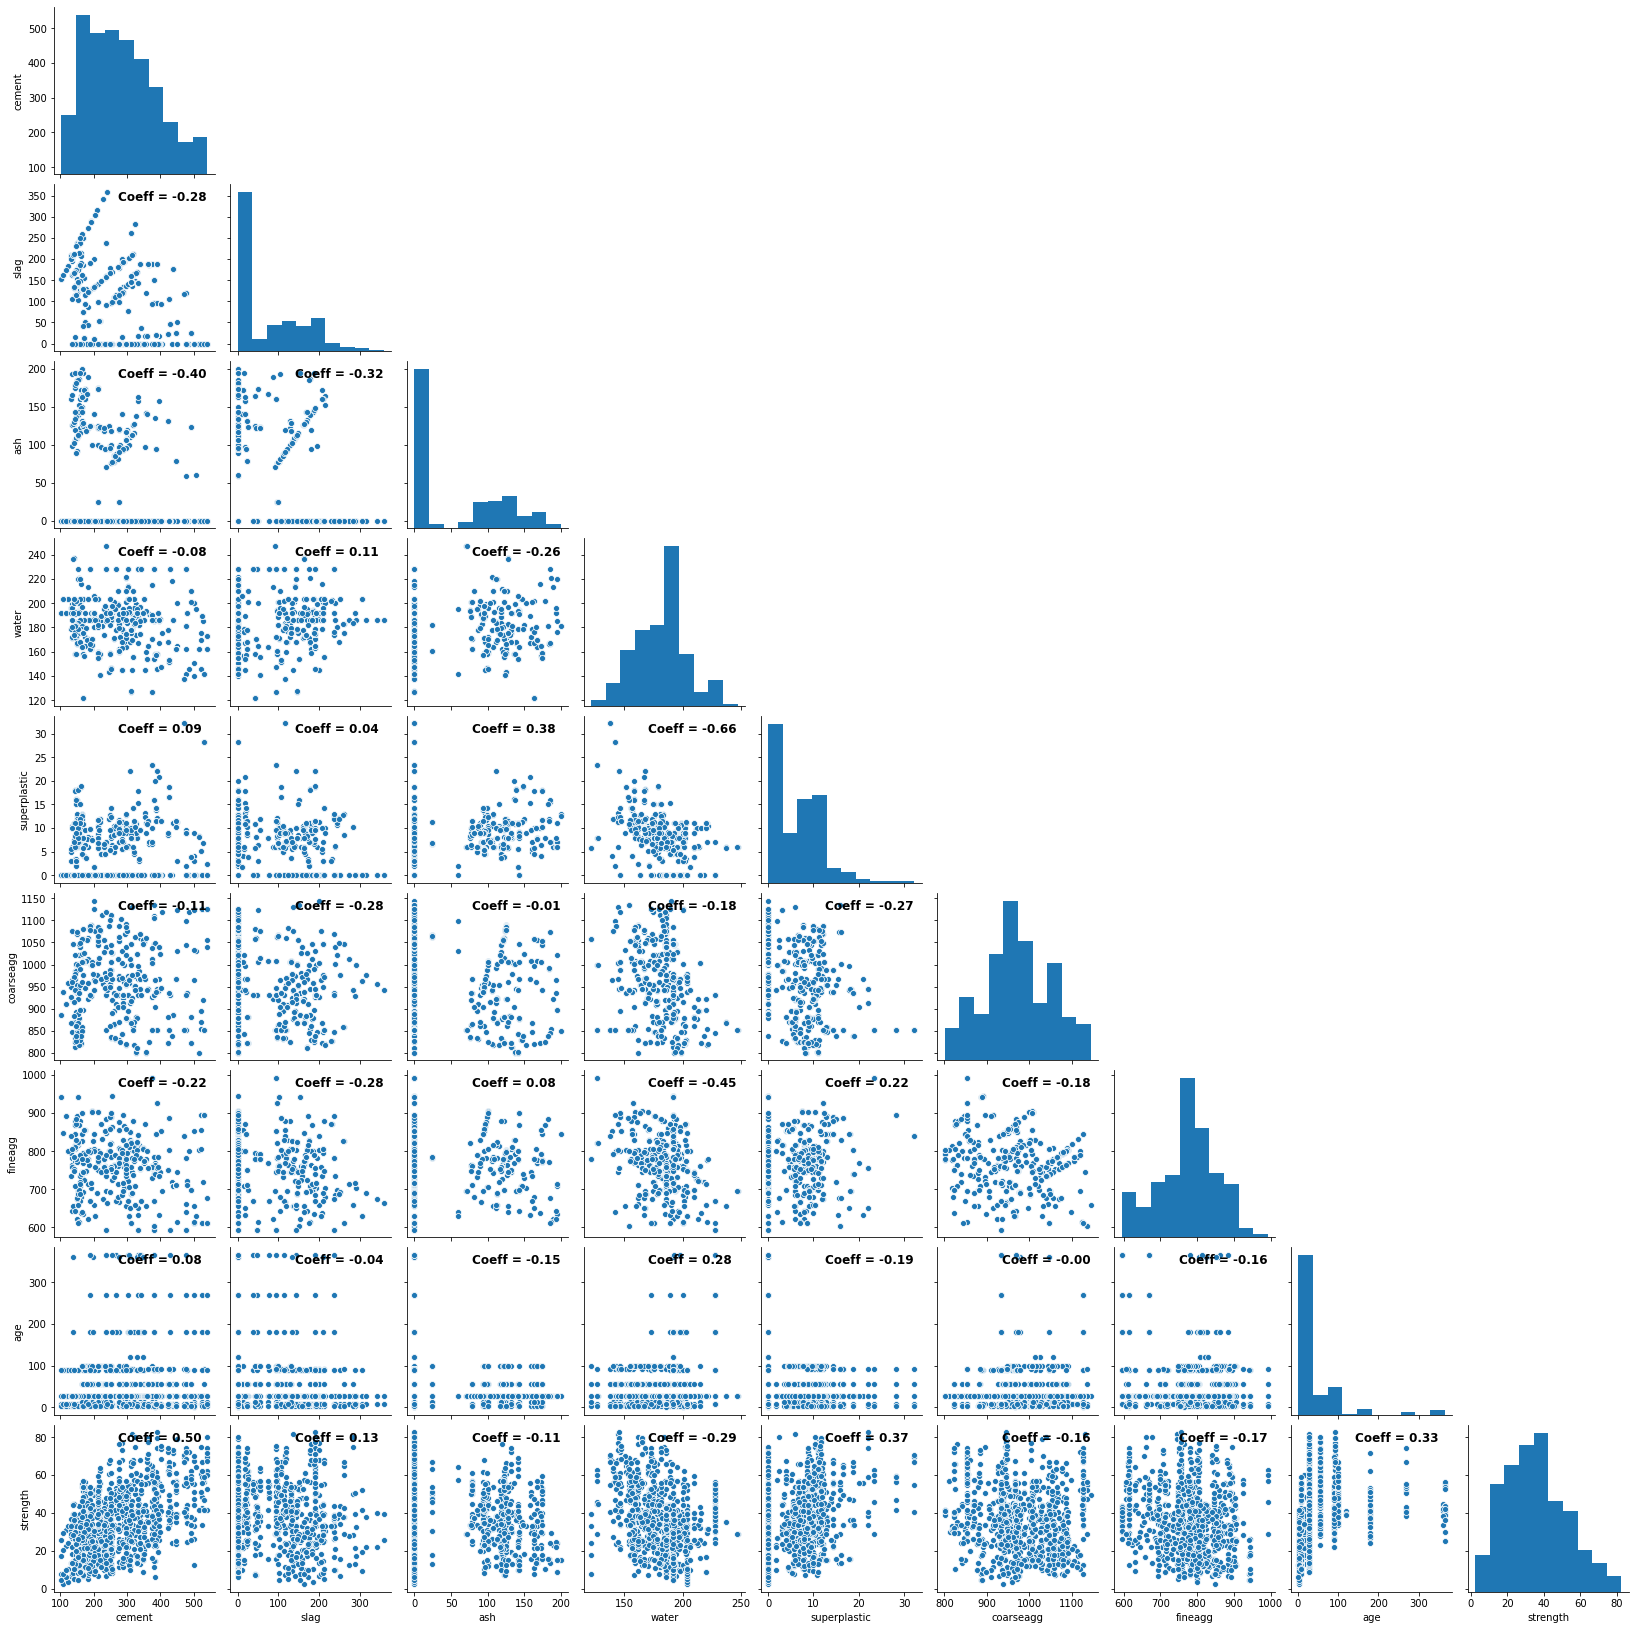

In [8]:
#fig, ax = plt.subplots(figsize=[20,10])
from scipy.stats import pearsonr
def corrfunc(x, y,  **kws):
  corr,_ = pearsonr(x, y)
  ax = plt.gca()
  ax.annotate("Coeff = {:.2f}".format(corr), xy=(0.4, 0.9), xycoords=ax.transAxes, fontsize = 'large', fontweight = 'bold')
def hide_axis(*args, **kws):
  plt.gca().set_visible(False)
pair= sns.pairplot(df)
pair.map_lower(corrfunc)
pair.map_upper(hide_axis)

#### Pipeline

* We are using Pipeline feature available in Scikit Learn to build our model.
* Pipelines helps to bulid a better readable organized model.
* It helps to process the train, test dataset seperately which refrains the model from data leakage.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

pipeline_linear = Pipeline([
                  ('scaling', StandardScaler()),
                  ('poly_features', PolynomialFeatures(interaction_only=True)),
                  ('algorithm', Ridge())
])
pipeline = Pipeline([
                  ('scaling', StandardScaler()),
                  ('algorithm', SVR())
])

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score

x = df.iloc[:, :-1]
y = df.iloc[:,-1]
seed = 3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = seed)

##### Model Complexity
* We could see that most of the features are not having direct impact on the target.
* So we may try to increase the model complexity and use regularized linear models like Ridge and Lasso.
* Ridge and Lasso will usually work better with polynomial features.

In [11]:
linear_models = {'Linear Regression':LinearRegression(), 'Ridge': Ridge(), 'Lasso' : Lasso()}
performance = pd.DataFrame(columns = ['Algorithm', 'Train R2 Score', 'Test R2 Score',  'CrossVal Mean R2 Score', 'CrossVal Deviation in R2 Score' ])
for model in linear_models:
  pipeline_linear.set_params(algorithm = linear_models[model])
  pipeline_linear.fit(x_train, y_train)
  cv = cross_val_score(pipeline_linear, X=x, y=y, cv =5)
  performance = performance.append({'Algorithm': model,
                      'Train R2 Score': np.round(pipeline_linear.score(x_train, y_train),2),
                      'Test R2 Score': np.round(pipeline_linear.score(x_test, y_test),2),
                      'CrossVal Mean R2 Score': np.round(cv.mean(),2),
                      'CrossVal Deviation in R2 Score': np.round(cv.std()*2,2)}, ignore_index = True)

In [12]:
performance

,Algorithm,Train R2 Score,Test R2 Score,CrossVal Mean R2 Score,CrossVal Deviation in R2 Score
0,Linear Regression,0.75,0.75,0.72,0.05
1,Ridge,0.75,0.75,0.72,0.05
2,Lasso,0.61,0.62,0.59,0.08


* Also we are trying with some other models without introducing the polynomial features.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models = {'SVM Regression': SVR(), 'KNN Regression':KNeighborsRegressor(),
                 'RandomForest Regression': RandomForestRegressor(random_state = seed), 'AdaBoost Regression' : AdaBoostRegressor(), 
                 'GradientBoosting Regression' : GradientBoostingRegressor(),'XGBoost Regression': XGBRegressor(random_state = seed,objective ='reg:squarederror') }
for model in models:
  pipeline.set_params(algorithm = models[model])
  pipeline.fit(x_train, y_train)
  cv = cross_val_score(pipeline, X=x, y=y, cv =5)
  performance = performance.append({'Algorithm': model,
                      'Train R2 Score': np.round(pipeline.score(x_train, y_train),2),
                      'Test R2 Score': np.round(pipeline.score(x_test, y_test),2),
                      'CrossVal Mean R2 Score': np.round(cv.mean(),2),
                      'CrossVal Deviation in R2 Score': np.round(cv.std()*2,2)}, ignore_index = True)

* From this report we could see that ensemble models without polynomial features performed better than Ridge and Lasso.
* Also i checked with polynomial features for emsemble models which have not increased thee performance much. 
* So we are trying to tune hyperparameter of ensemble models to get some better performance.

In [14]:
performance

,Algorithm,Train R2 Score,Test R2 Score,CrossVal Mean R2 Score,CrossVal Deviation in R2 Score
0,Linear Regression,0.75,0.75,0.72,0.05
1,Ridge,0.75,0.75,0.72,0.05
2,Lasso,0.61,0.62,0.59,0.08
3,SVM Regression,0.65,0.64,0.64,0.05
4,KNN Regression,0.81,0.72,0.70,0.08
5,RandomForest Regression,0.98,0.88,0.91,0.04
6,AdaBoost Regression,0.83,0.77,0.78,0.04
7,GradientBoosting Regression,0.95,0.90,0.90,0.03
8,XGBoost Regression,0.95,0.89,0.90,0.03


In [15]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
params_randomforest = {
    'algorithm': [RandomForestRegressor(max_features=0.8, random_state = seed)],
    'algorithm__n_estimators': range(50,1001,50),
    'algorithm__max_features': [0.4,0.5,0.6,0.7,0.8,0.9]
}
params_gradboost = {
    'algorithm': [GradientBoostingRegressor( random_state = seed)],
    'algorithm__n_estimators': [650],  #range(50,1001,50),
    'algorithm__learning_rate':  [0.1]#[0.1, 0.01, 0.05]
}
params_xgboost = {
    'algorithm': [XGBRegressor(objective ='reg:squarederror',random_state= seed)],
    'algorithm__n_estimators': range(50,1001,50),
    'algorithm__booster': ['gbtree', 'gblinear'],
    'algorithm__gamma': [1.5, 2, 3, 4],
    'algorithm__subsample': [0.6, 0.8, 1.0],
    'algorithm__colsample_bytree': [0.6, 0.8, 1.0],
    'algorithm__max_depth': [3, 4, 5],
    'algorithm__learning_rate': [0.01, 0.05, 0.1]
}
#creating the dict to pass the models in loop 
params_dict = {'Randomforest Tuned':params_randomforest, 'GradientBoost Tuned':params_gradboost,
               'XGBoost Tuned':params_xgboost}
#array to save the best paramtered model
best_models = []
for model in params_dict:
  r_search = RandomizedSearchCV(pipeline, params_dict[model], scoring='r2', cv =5)
  r_search.fit(x_train, y_train)
  cross_val = cross_val_score(r_search.best_estimator_, X=x, y=y, cv=5)
  # print(r_search.score(x_train, y_train))
  # print(r_search.score(x_test, y_test))
  # print(cross_val.mean())
  # print(cross_val.std()*2)
  # print(cross_val)
  best_models.append(r_search.best_estimator_)
  performance = performance.append({'Algorithm': model, 
                        'Train R2 Score': np.round(r_search.score(x_train, y_train),2),
                        'Test R2 Score': np.round(r_search.score(x_test, y_test),2),
                        'CrossVal Mean R2 Score': np.round(cross_val.mean(),2),
                        'CrossVal Deviation in R2 Score': np.round(cross_val.std()*2,2)}, ignore_index = True)

##### Feature importance
* From the above tuned model fetched the proportion of importance given to each features.
* As we checked in correlation pairplot, we could see that Age and cement plays a major role in prediction
* Also water have more importance here. We also noted water have some negative correlation to strength. 

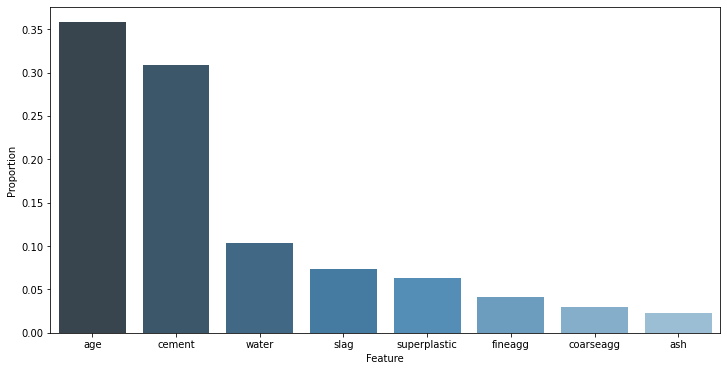

In [16]:
column = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg','fineagg', 'age']
proportion = best_models[0].named_steps['algorithm'].feature_importances_
imp =  pd.DataFrame({ 'Feature': column, 'Proportion': proportion}).sort_values('Proportion', ascending=False)
fig, ax = plt.subplots(figsize=[12, 6])
sns.barplot(x='Feature', y='Proportion', data=imp, palette=("Blues_d"))

##### Tuned model performance
* From the performance plot we could see that XGBoost and Gradient Boost performed well but XGBoost also have least deviation in cross validation score. 
* So we can choose XGBoost as best model for this prediction.

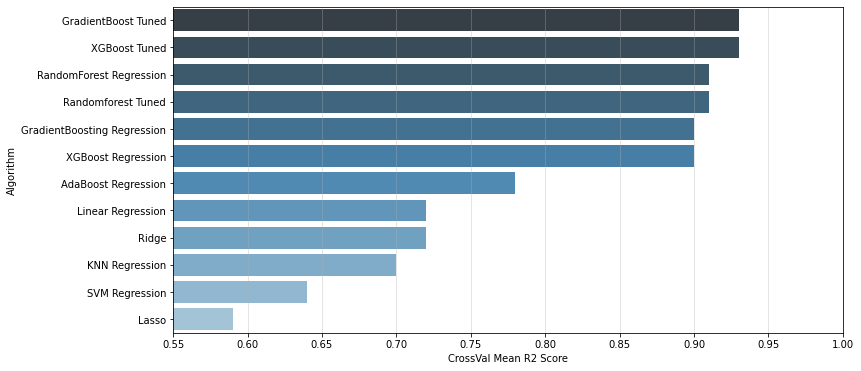

In [17]:
fig, ax = plt.subplots(figsize=[12, 6])
sorted = performance.sort_values('CrossVal Mean R2 Score',ascending = False)
plot = sns.barplot(y='Algorithm', x='CrossVal Mean R2 Score', data = sorted, orient = 'h',
            palette=("Blues_d"))
plot.set(xlim=(0.55,1))
plot.grid(axis = 'x', alpha=0.4) 

In [18]:
sorted

,Algorithm,Train R2 Score,Test R2 Score,CrossVal Mean R2 Score,CrossVal Deviation in R2 Score
10,GradientBoost Tuned,0.99,0.92,0.93,0.03
11,XGBoost Tuned,0.98,0.93,0.93,0.02
5,RandomForest Regression,0.98,0.88,0.91,0.04
9,Randomforest Tuned,0.98,0.89,0.91,0.04
7,GradientBoosting Regression,0.95,0.90,0.90,0.03
8,XGBoost Regression,0.95,0.89,0.90,0.03
6,AdaBoost Regression,0.83,0.77,0.78,0.04
0,Linear Regression,0.75,0.75,0.72,0.05
1,Ridge,0.75,0.75,0.72,0.05
4,KNN Regression,0.81,0.72,0.70,0.08
